## Multi-label Classification with scikit-multilearn

### 1. Introduction

We typically group supervised machine learning problems into classification and regression problems. Within the classification problems sometimes, multiclass classification models are encountered where the classification is not binary but we have to assign a class from `n` choices. 

In multi-label classification, instead of one target variable $y$, we have multiple target variables $y_1$, $y_2$, ..., $y_n$. For example there can be multiple objects in an image and we need to correctly classify them all or we are attempting predict which combination of a product that a customer would buy. 

Certain decision tree based algorithms in [Scikit-Learn](http://scikit-learn.org/stable/modules/multiclass.html) are naturally able to handle multi-label classification. In this post we explore the [scikit-multilearn library](http://scikit.ml/) which leverages Scikit-Learn and is built specifically for multi-label problems. 


### 2. Datasets

We use the **MediaMill** [dataset](https://ivi.fnwi.uva.nl/isis/mediamill/challenge/data.php) to explore different multi-label algorithms available in Scikit-Multilearn. Our goal is not to optimize classifier performance but to explore the various algorithms applicable to multi-label classification problems. The dataset is reasonable with over 30k train points and 12k test points. There are 120 features and 101 labels. 

This dataset was chosen in order to work with a fairly large dataset to illustrate difficulties in multi-label classification instead of a toy example. In particular when there are $N$ labels, the search space increases exponentially to $2^N$. A list of multi-label datasets can be found at Manik Varma's [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html). The data is provided in sparse format and the authors only provide Matlab scripts to convert them; some data wrangling is needed in python to handle them. 




In [1]:
from scipy import sparse
import gc

f = open(r'C:\Users\david\Downloads\Mediamill\Mediamill_data.txt',
'r',encoding='utf-8')
#f = open(r'C:\Users\kaoyuant\Downloads\Mediamill\Mediamill_data.txt',
#         'r',encoding='utf-8')

size = f.readline()
nrows, nfeature,nlabel = [int(s) for s in size.split()]
x_m = [[] for i in range(nrows)]
pos = [[] for i in range(nrows)]
y_m = [[] for i in range(nrows)]

for i in range(nrows):
    line = f.readline()
    temp=[s for s in line.split(sep=' ')]
    pos[i]=[int(s.split(':')[0]) for s in temp[1:]]
    x_m[i]=[float(s.split(':')[1]) for s in temp[1:]]
    for s in temp[0].split(','):
        try:
            int(s)
            y_m[i]=[ int(s) for s in temp[0].split(',')]
        except:
            y_m[i]=[]
          
      


f = open(r'C:\Users\david\Downloads\Mediamill\Mediamill_trSplit.txt',
'r',encoding='utf-8')
#f = open(r'C:\Users\kaoyuant\Downloads\Mediamill\Mediamill_trSplit.txt',
#         'r',encoding='utf-8')
train=f.readlines()

f = open(r'C:\Users\david\Downloads\Mediamill\Mediamill_tstSplit.txt',
'r',encoding='utf-8')
#f = open(r'C:\Users\kaoyuant\Downloads\Mediamill\Mediamill_tstSplit.txt',
#         'r',encoding='utf-8')
test=f.readlines()


select=0
train_=[int(s.split()[select])-1 for s in train]
test_=[int(s.split()[select])-1 for s in test]

xm_train=[x_m[i] for i in train_]
ym_train=[y_m[i] for i in train_]

xm_test=[x_m[i] for i in test_]
ym_test=[y_m[i] for i in test_]



x_train=sparse.lil_matrix((len(train_),nfeature))
for i in range(len(train_)):
    for j in range(len(pos[i])):
        x_train[i,pos[i][j]]=xm_train[i][j]

x_test=sparse.lil_matrix((len(test_),nfeature))
for i in range(len(test_)):
    for j in range(len(pos[i])):
        x_test[i,pos[i][j]]=xm_test[i][j]

del x_m, xm_train, pos,xm_test
gc.collect()

y_train=sparse.lil_matrix((len(train_),nlabel))
for i in range(len(train_)):
    for j in ym_train[i]:
        y_train[i,j]=1

y_test=sparse.lil_matrix((len(test_),nlabel))
for i in range(len(test_)):
    for j in ym_test[i]:
        y_test[i,j]=1

del y_m, ym_train, ym_test
gc.collect()  


0

### 3. Label Graph

When the label space is large, we can try to explore it using graph methods. Each label is a node in the graph and an edge exists when labels co-occur, weighted by the frequency of co-occurence.  

In [2]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True,
                                              include_self_edges=False)

label_names=[i for i in range(nlabel)]
edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))


101 labels, 2213 edges


Once we have constructed the label graph, we can apply graph algorithms on it to explore and understand it. 

One possibility is to cluster similar labels together so that they are processed together by the multilabel classification algorithms. Community detection methods such as the [Louvain algorithm](https://en.wikipedia.org/wiki/Louvain_Modularity) allow us to cluster the label graph. This is implemented in the `NetworkXLabelGraphClusterer` with the parameter `methods = louvain`.

In [3]:

from skmultilearn.cluster import NetworkXLabelGraphClusterer

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')


In [4]:
partition = clusterer.fit_predict(x_train,y_train)
membership_vector = to_membership_vector(partition)
print('There are', len(partition),'clusters')

There are 3 clusters


Our graph can be visualized with NetworkX. We use the force or spring layout for better visibility. 

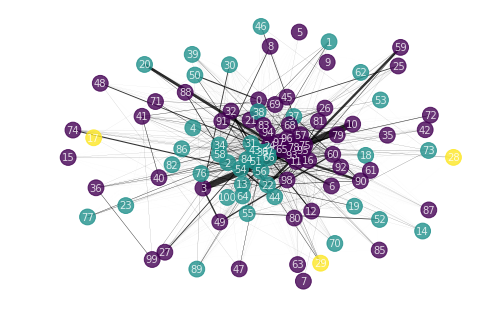

In [9]:
import networkx as nx
names_dict = dict(enumerate(x for x in label_names))
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(
    clusterer.graph_,
    pos=nx.spring_layout(clusterer.graph_,k=4),
    labels=names_dict,
    with_labels = True,
    width = [10*x/y_train.shape[0] for x in clusterer.weights_['weight']],
    node_color = [membership_vector[i] for i in range(y_train.shape[1])],
    cmap=plt.cm.viridis,
    node_size=250,
    font_size=10,
    font_color='white',
    alpha=0.8
)

We get 3 clusters. It might make sense to group them together when we send them to the multilabel  algorithm. Certain labels have lower centrality, indicating less influence from other labels. It is possible to predict these labels first before predicting the more central labels when using the chained classifier algorithm (see below).

### 4. Metric  

Before going into the details of each multilabel classification method, we select a metric to gauge how well the algorithm is performing. Similar to a classification problem it is possible to use `Hamming Loss`, `Accuracy`, `Precision`, `Jaccard Similarity`, `Recall`, and `F1 Score`. These are available from Scikit-Learn. 

Going forward we'll chose the `F1 Score` as it averages both `Precision` and `Recall`. We set the parameter `average = micro` to calculate metrics globally. There are many labels and some labels are not predicted; using `average = weighted` will result in the score for certain labels to be set to `0` before averaging.

It is also helpful to plot the confusion matrix to understand how the classifier is performing, but in our case there are too many labels to visualize.




### 5. Multilabel Classifiers - Algorithm Adaptation

Algorithm Adaptation, as indicated by it's name, extend single label classification to the multi-label context, usually by changing the cost or decision functions. 

#### 5a. Algorithm Adaptation - MLkNN

Multi-label K Nearest Neighbours uses k-Nearest Neighbors to find nearest examples to a test class and uses Bayesian inference to predict labels. This is a distance based method and works well when there is a relationship between distance and labels. Parameters `k` and `s` need to be determined. This can be done using the `GridSearchCV` function from sklearn. 

In [36]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
import time

parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}
score = 'f1_micro'

start=time.time()

classifier = GridSearchCV(MLkNN(), parameters, scoring=score)
classifier.fit(x_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')
print('best parameters :', classifier.best_params_, 'best score: ',
      clf.best_score_)


training time taken:  15720.0 seconds


NameError: name 'clf' is not defined

In [38]:
print('best parameters :', classifier.best_params_, 
      'best score: ',classifier.best_score_)


best parameters : {'k': 1, 's': 0.5} best score:  0.5946738355601814


#### 5b. Algorithm Adaptation - BRkNNaClassifier

Short hand for Binary Relevance k-Nearest Neighbours. A k-Nearest Neighbour is trained per label. This requires a lot of compute for a large label space. 


In [40]:
from skmultilearn.adapt import BRkNNaClassifier

parameters = {'k': range(3,5)}
score = 'f1_micro'

start=time.time()

classifier = GridSearchCV(BRkNNaClassifier(), parameters, scoring=score)
classifier.fit(x_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')
print('best parameters :', classifier.best_params_,
      'best score: ',classifier.best_score_)


training time taken:  1572.0 seconds
best parameters : {'k': 3} best score:  0.6020060621186349


### 6. Multilabel Classifiers - Problem Transformation

#### 6a. Problem Transformation : Binary Relevance 

Binary relevance is simple; each target variable ($y_1$, $y_2$,..,$y_n$) is treated independently and we are reduced to $n$ classification problems. `Scikit-Multilearn` implements this for us, saving us the hassle of splitting the dataset and training each of them separately.  

This classifier can generalize beyond labels present in the training set. However it is very slow if the label space is large.

In [11]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import time

start=time.time()
classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

classifier.fit(x_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')



C:\Users\david\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


training time taken:  606.0 seconds


In [12]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  42.0 seconds


In [13]:
import sklearn.metrics as metrics

br_f1=metrics.f1_score(y_test, y_hat, average='micro')
br_hamm=metrics.hamming_loss(y_test,y_hat)
print('Binary Relevance F1-score:',round(br_f1,3))
print('Binary Relevance Hamming Loss:',round(br_hamm,3))

Binary Relevance F1-score: 0.591
Binary Relevance Hamming Loss: 0.028


#### 6b. Problem Transformation - Label Powerset

This method transforms the problem into a multiclass classification problem; the target variables ($y_1$, $y_2$,..,$y_n$) are combined and each combination is treated as a unique class. This method will produce many classes. 

This transformation reduces the problem to only one classifier but, all possible labels need to be present in the training set. 

In [49]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

start=time.time()
classifier.fit(x_train, y_train)
print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  625.0 seconds


In [50]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  134.0 seconds


In [51]:

lp_f1=metrics.f1_score(y_test, y_hat, average='micro')
lp_hamm=metrics.hamming_loss(y_test,y_hat)
print('Label Powerset F1-score:',round(lp_f1,3))
print('Label Powerset Hamming Loss:',round(lp_hamm,3))

Label Powerset F1-score: 0.582
Label Powerset Hamming Loss: 0.031


#### 6c. Problem Transformation - Classifier Chains 

Classifier chains are akin to binary relevance, however the target variables ($y_1$, $y_2$,.., $y_n$) are not fully independent. The features ($x_1$, $x_2$,.., $x_m$) are initially used to predict $y_1$. Next ($x_1$, $x_2$,.., $x_m$, $y_1$) is used to predict $y_2$. At the $n^{th}$ step, ($x_1$, $x_2$,.., $x_m$, $y_1$,.., $y_{n-1}$) predicts $y_n$. The ordering in which the labels are predicted can be determined by the user and can greatly influence the results. 

This classifier takes label dependencies into account and generalizes to label combinations not present in the training data. However the quality of the classifier is heavily dependent on the ordering; there are $n!$ possible orderings and this method is slow if the label space is large. 

In [15]:
from skmultilearn.problem_transform import ClassifierChain

classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True],
    order=[i for i in range(nlabel)]
)
start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  549.0 seconds


In [53]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  12.0 seconds


In [16]:
cc_f1=metrics.f1_score(y_test, y_hat, average='micro')
cc_hamm=metrics.hamming_loss(y_test,y_hat)
print('Classifier Chain F1-score:',round(cc_f1,3))
print('Classifier Chain Hamming Loss:',round(cc_hamm,3))

Classifier Chain F1-score: 0.591
Classifier Chain Hamming Loss: 0.028


Based on our construction of the label space Graph, we try to order the labels by increasing betweeness centrality; poorly connected labels will first be trained and then used to classify other labels. 

In [17]:
from operator import itemgetter
sorted_deg = [s[0] for s in sorted(nx.betweenness_centrality(clusterer.graph_).items(),
                                   key=itemgetter(1))]
classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True],
    order=sorted_deg
)
start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  581.0 seconds


In [18]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  12.0 seconds


In [19]:
cco_f1=metrics.f1_score(y_test, y_hat, average='micro')
cco_hamm=metrics.hamming_loss(y_test,y_hat)
print('Classifier Chain Ordered F1-score:',round(cco_f1,3))
print('Classifier Chain Ordered Hamming Loss:',round(cco_hamm,3))

Classifier Chain Ordered F1-score: 0.018
Classifier Chain Ordered Hamming Loss: 0.063


Classifying by increasing betweeness centrality produces very poor results as seen above. If we were to order the chain by decreasing betweeness centrality we still get poor results. 

In [20]:
rev_sorted_deg = [s[0] for s in sorted(nx.betweenness_centrality(clusterer.graph_).items(),
                                   key=itemgetter(1),
                 reverse=True)]

classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True],
    order=rev_sorted_deg
)
start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  456.0 seconds


In [21]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  10.0 seconds


In [22]:
ccr_f1=metrics.f1_score(y_test, y_hat, average='micro')
ccr_hamm=metrics.hamming_loss(y_test,y_hat)
print('Classifier Chain Reverse Ordered F1-score:',round(ccr_f1,3))
print('Classifier Chain Reverse Ordered Hamming Loss:',round(ccr_hamm,3))

Classifier Chain Reverse Ordered F1-score: 0.011
Classifier Chain Reverse Ordered Hamming Loss: 0.068


These results illustrate the dependence on the order of the labels. Unfortunately we did not get the improvement hoped for by using the ordering derived from the label graph. 

### 7. Multilabel Classifiers - Ensembles of Classifiers

This class uses [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) with the base classifier being a multi-label classifier.

#### 7a. Ensembles of Classifiers - LabelSpacePartitioningClassifier
The label space is partitioned into separate sub label spaces, for example by constructing a label graph and applying a graph clustering/community detection algorithm like we did in section 3. A base multi-label subclassifier is trained on each subspace. The result is predicted with each of the subclassifiers and we take the **sum**

This method adapts the classifiers according to the label space and requires less classifiers than binary relevance. On the downside, the label combination has to be present in the training dataset in order to be predicted and partitioning might prevent correct classification of certain label combinations. 

In [26]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

classifier = LabelSpacePartitioningClassifier(
    classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
),
    clusterer  = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
)

start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')


training time taken:  612.0 seconds


In [27]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  5.0 seconds


In [28]:
part_f1=metrics.f1_score(y_test, y_hat, average='micro')
part_hamm=metrics.hamming_loss(y_test,y_hat)
print('Label Space Partitioning Classifier F1-score:',round(part_f1,3))
print('Label Space Partitioning Classifier Hamming Loss:',round(part_hamm,3))

Label Space Partitioning Classifier F1-score: 0.591
Label Space Partitioning Classifier Hamming Loss: 0.028


#### 7b. Ensembles of Classifiers - Majority Voting Classifier
This is similar to the Label Space Partitioning Classifier but the **majority vote** is used instead. 


In [29]:
from skmultilearn.ensemble import MajorityVotingClassifier

classifier = LabelSpacePartitioningClassifier(
    classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
),
    clusterer  = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
)

start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')


training time taken:  621.0 seconds


In [30]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  5.0 seconds


In [31]:
majo_f1=metrics.f1_score(y_test, y_hat, average='micro')
majo_hamm=metrics.hamming_loss(y_test,y_hat)
print('Majority Voting Classifier F1-score:',round(majo_f1,3))
print('Majority Voting Classifier Hamming Loss:',round(majo_hamm,3))

Majority Voting Classifier F1-score: 0.591
Majority Voting Classifier Hamming Loss: 0.028


### 8.  Conclusion 

Multi-label classification methods allow us to classify data sets with more than 1 target variable and is an area of active research. There are various methods which should be used depending on the dataset on hand. A variety of base classifiers can be chosen; Random Forest was used for simplicity and to minimize calculation time. 

The **MediaMill** dataset is among the smallest in the [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html). The methods explored above would be far too slow if applied on datasets with label dimensionality of hundreds of thousands or millions. Datasets with a large number of possible labels require different approaches which will be explored in a separate post. 